In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn import preprocessing
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.data import Dataset

import time
import pickle
import re
import itertools
import gc

In [2]:
class DataPrep:
    def __init__(self):
        pass
    
    def generate_feature_list(self, dataframe, features_name):
    
        """
        Generate features list for mapping 
    
        Parameters
        ----------
            dataframe: Dataframe
                Pandas Dataframe for Books. 
            features_name : List
                List of feature columns name avaiable in dataframe. 

        Returns
        -------
            List of all features for mapping 
        """
        features = dataframe[features_name].apply(lambda x: ','.join(x.map(str)), axis=1)
        features = features.str.split(',')
        features = features.apply(pd.Series).stack().reset_index(drop=True)
    
        return features

    def create_features(self, dataframe, features_name, id_col_name):
        """
        Generate features that will be ready for feeding into lightfm
    
        Parameters
        ----------
            dataframe: Dataframe
                Pandas Dataframe which contains features
            features_name : List
                List of feature columns name avaiable in dataframe
            id_col_name: String
                Column name which contains id of the item e.g.: "book_id"

        Returns
        -------
            Pandas Series
                A pandas series containing process features
                that are ready for feed into lightfm.
                The format of each value
                will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
        """

        features = dataframe[features_name].apply(lambda x: ','.join(x.map(str)), axis=1)
        features = features.str.split(',')
        features = list(zip(dataframe[id_col_name], features))
        return features

        
    def get_all_feature_data(self, metadata, interactions ,features_name, id_col_name, ):
            
        """
        Generate lighfm data for trainig the model
    
        Parameters
        ----------
            metadata: Dataframe
                Pandas Dataframe containing item features
            interactions: Dataframe
                Pandas Dataframe containing user-item interactions
            features_name : List
                List of feature columns name avaiable in dataframe. 
            id_col_name: String
                The item_id column name
        Returns
        -------
            List of all features for mapping 
        """
        book_sentiments = metadata[metadata.book_id.isin(interactions.book_id)]
        
        features_list = self.generate_feature_list(book_sentiments, features_name)
        book_features = self.create_features(book_sentiments, features_name, id_col_name)
        

        dataset = Dataset(user_identity_features=False)
        dataset.fit(interactions['user_id'].unique(), 
                    book_sentiments['book_id'].unique(),
                    item_features=features_list)
        
        lightfm_item_features = dataset.build_item_features(book_features)
        
        interactions = list(zip(interactions.user_id,
                                interactions.book_id,
                                interactions.rating))

        lightfm_interactions, lightfm_weights = dataset.build_interactions(interactions)
        
        user_id_mapping = pd.DataFrame(list(dataset.mapping()[0].items()), columns=['user_id', 'inner_uid'])
        item_id_mapping = pd.DataFrame(list(dataset.mapping()[2].items()), columns=['book_id', 'inner_iid'])
    
        
        return lightfm_item_features, lightfm_interactions, lightfm_weights, user_id_mapping, item_id_mapping

In [3]:
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """
    while True:
        yield {
            "no_components": np.random.randint(10, 100),
            "learning_schedule": np.random.choice(["adagrad"]),
            "loss": np.random.choice(["warp"]),
            "learning_rate": np.random.exponential(0.001),
            "item_alpha": np.random.exponential(0.0005),
            "max_sampled": np.random.randint(5, 10),
            "num_epochs": np.random.randint(10,200)
        }

def random_search(train, test, item_features, weights, num_threads, num_samples):
    """
        Create a lighfm model given the hyperparameters, evaluates AUC score and returns the
        best score, model and hyperparameters
    
        Parameters
        ----------
            train: output of a train_test_split() method or a coo_matrix
            test: output of a train_test_split() method or a coo_matrix
            item_features : csr_matrix containing item_features
            weights: weights matrix
            num_threads: number
            num_samples: number
        Returns
        -------
            best score, model and hyperparameters
    """
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams )
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train,
                  item_features=item_features, sample_weight=weights,
                  epochs=num_epochs, num_threads=num_threads, verbose=True)
        score = auc_score(model, test, train_interactions=train, num_threads=num_threads, item_features=item_features).mean()
        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)
        
def random_search_without_features(train, test, weights, num_threads, num_samples):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams )
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train,
                  sample_weight=weights,
                  epochs=num_epochs, num_threads=num_threads, verbose=True)
        score = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()
        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


In [4]:
#Read data from files

sentiments = pd.read_csv('../input/poetry-sentiment-scores/sentiment_scores.csv')
all_interactions = pd.read_json ('../input/all-poetry-interactions/goodreads_interactions_poetry.json', lines=True)
books_metadata = pd.read_json('../input/poetry-books/goodreads_books_poetry.json', lines=True)

#get mean sentiment score/overall sentiment score per book
book_sentiments = pd.DataFrame(sentiments.groupby(['book_id'])['compound'].mean())
book_sentiments = book_sentiments.reset_index()

#Round to 3 decimal places
book_sentiments['compound'] = np.round(book_sentiments['compound'], decimals = 3)

#Only user_id, book_id and rating are needed
all_interactions = all_interactions[['user_id', 'book_id','rating']]
all_interactions

#Drop interactions where rating is = 0
all_interactions = all_interactions[all_interactions.book_id.isin(book_sentiments.book_id)]
all_interactions = all_interactions[~(all_interactions['rating'] == 0 )]

# Make sure book metadata are available
book_sentiments= pd.merge(books_metadata,book_sentiments,on='book_id',how='left')
book_sentiments['compound'] = book_sentiments['compound'].fillna(((book_sentiments['average_rating']-1)/2)- 1)

#Books which are rated by at least 20 users and, users who have rated atleast 20 books will be considered
df1 = all_interactions.groupby('book_id').size().sort_values().reset_index(name='count')
df1.drop(df1[df1['count'] < 20].index, inplace = True)
all_interactions = all_interactions[(all_interactions.book_id.isin(df1.book_id))].dropna()

df2 = all_interactions.groupby('user_id').size().sort_values().reset_index(name='count')
df2.drop(df2[df2['count'] < 20].index, inplace = True)
all_interactions = all_interactions[(all_interactions.user_id.isin(df2.user_id))].dropna()

book_sentiments = book_sentiments[book_sentiments.book_id.isin(all_interactions.book_id)]

#del books_metadata
del df1
del df2
del sentiments

gc.collect

<function gc.collect(generation=2)>

In [5]:
len(all_interactions)

265072

In [6]:
all_interactions['user_id'].to_csv("user_id_list.csv", index=False)

In [7]:
len(book_sentiments)

5667

In [8]:
#Add more features if necessary
#book_sentiments['language_code'].replace(np.nan, 'unknown', inplace=True)
#book_sentiments['language_code'].replace('', 'unknown', inplace=True)
#book_sentiments['language_code'].replace('--', 'unknown', inplace=True)

#book_sentiments = book_sentiments[['book_id','compound', 'language_code']]

In [9]:
#Get interaction, item features and mappings
data_prep = DataPrep()
lightfm_item_features, lightfm_interactions, lightfm_weights, user_id_mapping, item_id_mapping = data_prep.get_all_feature_data(book_sentiments, all_interactions, ['compound'], 'book_id')


In [10]:
lightfm_item_features

<5667x6870 sparse matrix of type '<class 'numpy.float32'>'
	with 11334 stored elements in Compressed Sparse Row format>

In [11]:
lightfm_interactions

<6774x5667 sparse matrix of type '<class 'numpy.int32'>'
	with 265072 stored elements in COOrdinate format>

In [12]:
#split training, testing and validation data
train, test_intermediate = random_train_test_split(
                                        interactions=lightfm_interactions,
                                        test_percentage=0.20,
                                        random_state=100
                                        )
train_weight, test_intermediate_weight = random_train_test_split(
                                                                interactions=lightfm_weights,
                                                                test_percentage=0.20,
                                                                random_state=100
                                                                )
validation, test = random_train_test_split(
                                            interactions=test_intermediate,
                                            test_percentage=0.50,
                                            random_state=100
                                        )
validation_weight, test_weight = random_train_test_split(
                                                        interactions=test_intermediate_weight,
                                                        test_percentage=0.50,
                                                        random_state=100
                                                        )

In [13]:
#Returned model will have the model with the best parameters.
#(score, hyperparams, model) = max(random_search(train=train,
#                                                test=test, 
#                                                item_features=lightfm_item_features,
#                                                weights=train_weight, 
#                                                num_threads=2, 
#                                                 num_samples=10), key=lambda x: x[0])

#print("Best score {} at {}".format(score, hyperparams))


In [14]:
#Create model from the chosen hyperparameters
model = LightFM(no_components=93, 
                learning_schedule= 'adagrad', 
                loss='warp',
                learning_rate=0.004797, 
                item_alpha=5.071235338644859e-05,
                max_sampled=8)
model.fit(train,
          item_features=lightfm_item_features, sample_weight=train_weight,
          epochs=91, num_threads=2, verbose=True)
score = auc_score(model, test, train_interactions=train,item_features =lightfm_item_features, num_threads=2).mean()
print(score)

Epoch: 100%|██████████| 91/91 [00:58<00:00,  1.56it/s]


0.88538194


In [15]:
#Save model 
with open('saved_model','wb') as f:
    saved_model={'model':model}
    pickle.dump(saved_model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
#Precision and Recall
train_precision = precision_at_k(model, train, k=10,item_features=lightfm_item_features).mean()
test_precision = precision_at_k(model, test,train_interactions=train, k=10,item_features=lightfm_item_features).mean()
print("Train Precision: {}".format(train_precision))
print("Test Precision: {}".format(test_precision))

train_recall = recall_at_k(model, train, k=10, item_features=lightfm_item_features).mean()
test_recall = recall_at_k(model, test,train_interactions=train, k=10, item_features=lightfm_item_features).mean()
print("Train Recall: {}".format(train_recall))
print("Train Recall: {}".format(test_recall))

Train Precision: 0.2796870470046997
Test Precision: 0.049634356051683426
Train Recall: 0.108743044938925
Train Recall: 0.13952723090535687


In [17]:
precision_arr=precision_at_k(model, validation, train_interactions=train,k=10,item_features=lightfm_item_features)

In [18]:
print(precision_arr[:20])

[0.  0.  0.  0.  0.2 0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.  0.1 0.  0.
 0.2 0. ]


In [19]:
new_arr_no_0 = precision_arr[np.where(precision_arr!=0)]
new_arr_0 = precision_arr[np.where(precision_arr==0)]

In [20]:
print(len(precision_arr))
print(len(new_arr_no_0))
print(len(new_arr_0))

6451
2390
4061


In [21]:
sorted_arr = np.sort(new_arr_no_0)
print(sorted_arr)

[0.1 0.1 0.1 ... 0.4 0.5 0.5]


In [22]:
#Test on remaining validation data
val_auc = auc_score(model, validation, train_interactions=train, num_threads=2, item_features=lightfm_item_features).mean()
print('AUC: %s' % val_auc)

#Precision and Recall
val_precision = precision_at_k(model, validation,train_interactions=train, k=10,item_features=lightfm_item_features).mean()
print("Validation Precision: {}".format(val_precision))

val_recall = recall_at_k(model, validation,train_interactions=train, k=10, item_features=lightfm_item_features).mean()
print("Validation Recall: {}".format(val_recall))

AUC: 0.88675433
Validation Precision: 0.05084482952952385
Validation Recall: 0.14176730038258764


In [23]:
class MakeRecommendations:
    """
    Make prediction given model and user ids
    """
    def __init__(self, lightfm_model,
                 books,
                 item_features,
                 interactions,
                 user_id_mapping,
                 item_id_mapping):
        self.model = lightfm_model
        self.books = books
        self.item_features = item_features
        self.interactions = interactions
        self.user_id_map = user_id_mapping
        self.item_id_map = item_id_mapping

    def _filter_already_read_books(self, user_id):
        """Drop books already read(rated) by the user_id"""
       
        read_book_ids = self.interactions.loc[self.interactions['user_id'] == user_id,'book_id']
        books_for_prediction = self.item_id_map.loc[~self.item_id_map['book_id'].isin(read_book_ids.tolist())]

        return books_for_prediction

    def make_recommendations_per_user(self, user_ids, num_prediction=5, num_threads=1):
        

        inner_uid = self.user_id_map[(self.user_id_map['user_id'] == user_ids)].inner_uid.values[0]


        #get books already not read by the user.
        books_for_prediction = self._filter_already_read_books(user_ids)
        
        score = self.model.predict(
                            int(inner_uid),
                            books_for_prediction['inner_iid'].values.tolist(),
                            item_features=self.item_features)
        
        books_for_prediction = books_for_prediction.copy()
        books_for_prediction['recommendation_score'] = score
        books_for_prediction = books_for_prediction.sort_values( by='recommendation_score', ascending=False)[:num_prediction]
        
        print("User {} may be interested in the following books".format(user_ids))
        books_for_prediction = self.books.loc[self.books['book_id'].isin(books_for_prediction['book_id'])][['title']]
        print(books_for_prediction.to_markdown(index=False))
        
        return books_for_prediction
        

In [24]:
make_recommendations = MakeRecommendations(model,book_sentiments,lightfm_item_features, all_interactions, user_id_mapping, item_id_mapping )

In [25]:
preds = make_recommendations.make_recommendations_per_user('561130041c7cbc45193e38b5cd9eea83', num_prediction=10)

User 561130041c7cbc45193e38b5cd9eea83 may be interested in the following books
| title                                 |
|:--------------------------------------|
| Howl and Other Poems                  |
| The Iliad                             |
| The Canterbury Tales                  |
| Leaves of Grass                       |
| The Complete Poems of Emily Dickinson |
| A Light in the Attic                  |
| Where the Sidewalk Ends               |
| The Odyssey                           |
| The Waste Land and Other Poems        |
| Paradise Lost                         |


In [26]:
from scipy import sparse

sparse.save_npz("lightfm_item_features.npz", lightfm_item_features)
user_id_mapping.to_csv("user_id_mapping.csv", index=False)
item_id_mapping.to_csv("item_id_mapping.csv", index=False)
all_interactions.to_csv("all_interactions.csv", index=False)
book_sentiments[['book_id', 'title']].to_csv("books.csv", index=False)

In [27]:
def recall_precision_at_ks():
    n_recommendations = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    
    df = pd.DataFrame(columns = ['k','precision', 'recall'])
    for n in n_recommendations: 
        val_precision = precision_at_k(model, test_intermediate, k=n,item_features=lightfm_item_features).mean()
        val_recall = recall_at_k(model, test_intermediate, k=n, item_features=lightfm_item_features).mean()
        
        df = df.append({'k' : n, 'precision' : val_precision, 'recall' : val_recall},ignore_index = True)

    val_auc = auc_score(model, test_intermediate, train_interactions=train, num_threads=2, item_features=lightfm_item_features).mean()
    
    plt.plot(df['recall'], df['precision'], '-')
    plt.ylabel("Precision Scores")
    plt.xlabel("Recall Scores")
    plt.title("ROC Scores and Auc of " + str(round(val_auc, 2)))
    plt.show()
    return df

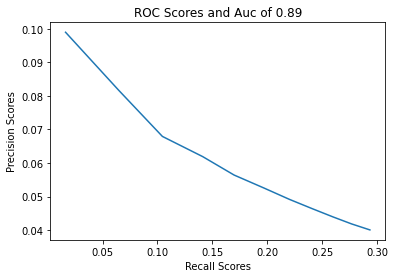

In [28]:
recall_precision_vals=recall_precision_at_ks()

In [29]:
recall_precision_vals

,k,precision,recall
0,1.0,0.099008,0.016310
1,5.0,0.081663,0.064802
2,10.0,0.067930,0.104483
3,15.0,0.061901,0.141187
4,20.0,0.056416,0.169701
5,25.0,0.052532,0.196967
6,30.0,0.049159,0.220072
7,35.0,0.046377,0.240883
8,40.0,0.043921,0.259767
9,45.0,0.041823,0.276752
